##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multilayer perceptrons for digit recognition with Core APIs

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/core/mlp_core"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/core/mlp_core.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/core/mlp_core.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/core/mlp_core.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook uses the [TensorFlow Core low-level APIs](https://www.tensorflow.org/guide/core) to build an end-to-end machine learning workflow for handwritten digit classification with [multilayer perceptrons](https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/anatomy) and the [MNIST dataset](http://yann.lecun.com/exdb/mnist). Visit the [Core APIs overview](https://www.tensorflow.org/guide/core) to learn more about TensorFlow Core and its intended use cases.

## Multilayer perceptron (MLP) overview

The Multilayer Perceptron (MLP) is a type of feedforward neural network used to approach [multiclass classification](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/video-lecture) problems. Before building an MLP, it is crucial to understand the concepts of perceptrons, layers, and activation functions.

Multilayer Perceptrons are made up of functional units called perceptrons. The equation of a  perceptron is as follows:

$$Z = \vec{w}⋅\mathrm{X} + b$$

where

* $Z$: perceptron output
* $\mathrm{X}$: feature matrix
* $\vec{w}$: weight vector
* $b$: bias

When these perceptrons are stacked, they form structures called dense layers which can then be connected to build a neural network. A dense layer's equation is similar to that of a perceptron's but uses a weight matrix and a bias vector instead: 

$$Z = \mathrm{W}⋅\mathrm{X} + \vec{b}$$

where

* $Z$: dense layer output
* $\mathrm{X}$: feature matrix
* $\mathrm{W}$: weight matrix
* $\vec{b}$: bias vector


In an MLP, multiple dense layers are connected in such a way that the outputs of one layer are fully connected to the inputs of the next layer. Adding non-linear activation functions to the outputs of dense layers can help the MLP classifier learn complex decision boundaries and generalize well to unseen data.

## Setup

Import TensorFlow, [pandas](https://pandas.pydata.org), [Matplotlib](https://matplotlib.org) and [seaborn](https://seaborn.pydata.org) to get started.

In [2]:
# Use seaborn for countplot.
!pip install -q seaborn

In [3]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tempfile
import os
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)
# Set random seed for reproducible results 
tf.random.set_seed(22)

2023-10-04 01:27:29.112043: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-04 01:27:29.112093: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-04 01:27:29.112126: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.14.0


## Load the data

This tutorial uses the [MNIST dataset](http://yann.lecun.com/exdb/mnist), and demonstrates how to build an MLP model that can classify handwritten digits. The dataset is available from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/mnist).

Split the MNIST dataset into training, validation, and testing sets. The validation set can be used to gauge the model's generalizability during training so that the test set can serve as a final unbiased estimator for the model's performance.


In [5]:
train_data, val_data, test_data = tfds.load("mnist", 
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

2023-10-04 01:27:32.380134: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


The MNIST dataset consists of handwritten digits and their corresponding true labels. Visualize a couple of examples below.

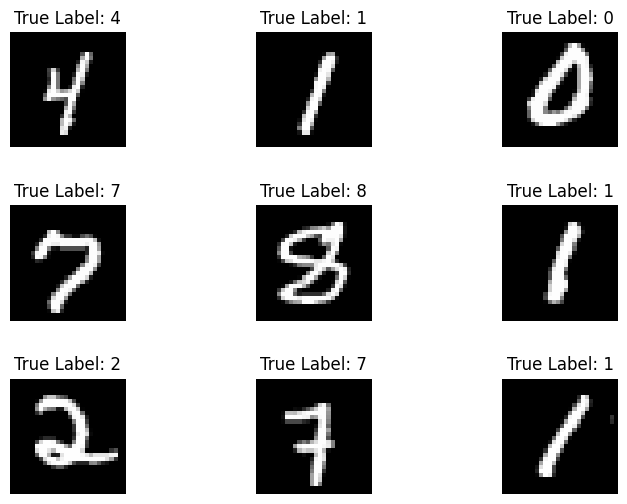

In [6]:
x_viz, y_viz = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0]
x_viz = tf.squeeze(x_viz, axis=3)

for i in range(9):
    plt.subplot(3,3,1+i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray')
    plt.title(f"True Label: {y_viz[i]}")
    plt.subplots_adjust(hspace=.5)


Also review the distribution of digits in the training data to verify that each class is well represented in the dataset.


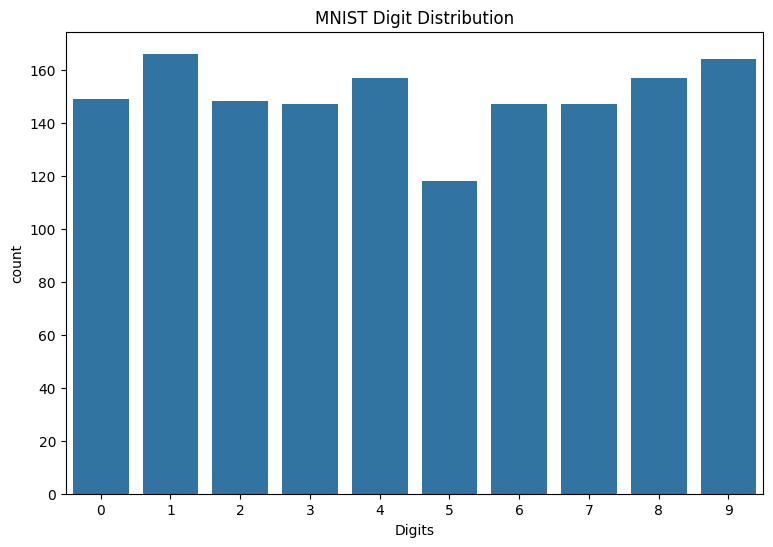

In [7]:
sns.countplot(x=y_viz.numpy());
plt.xlabel('Digits')
plt.title("MNIST Digit Distribution");

## Preprocess the data

First, reshape the feature matrices to be 2-dimensional by flattening the images. Next, rescale the data so that the pixel values of [0,255] fit into the range of [0,1]. This step ensures that the input pixels have similar distributions and helps with training convergence.

In [8]:
def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y

train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)

## Build the MLP 

Start by visualizing the [ReLU](https://developers.google.com/machine-learning/glossary#ReLU) and [Softmax](https://developers.google.com/machine-learning/glossary#softmax) activation functions. Both functions are available in `tf.nn.relu` and `tf.nn.softmax` respectively. The ReLU is a non-linear activation function that outputs the input if it is positive and 0 otherwise: 

$$\text{ReLU}(X) = max(0, X)$$

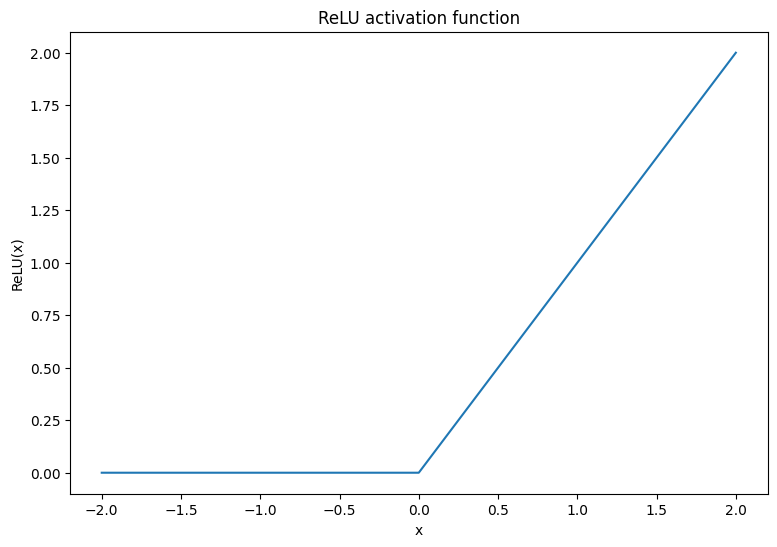

In [9]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.relu(x));
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU activation function');

The softmax activation function is a normalized exponential function that converts $m$ real numbers into a probability distribution with $m$ outcomes/classes. This is useful for predicting class probabilities from a neural network's output:

$$\text{Softmax}(X) = \frac{e^{X}}{\sum_{i=1}^{m}e^{X_i}}$$

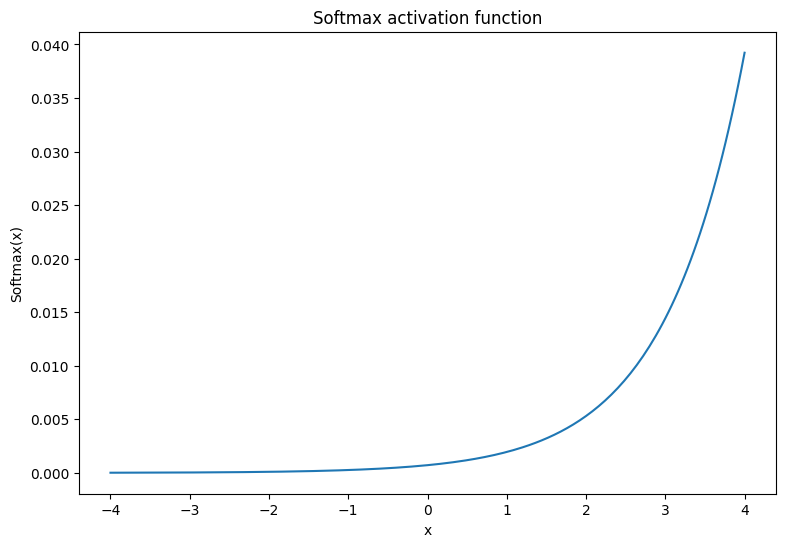

In [10]:
x = tf.linspace(-4, 4, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.softmax(x, axis=0));
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.title('Softmax activation function');

### The dense layer

Create a class for the dense layer. By definition, the outputs of one layer are fully connected to the inputs of the next layer in an MLP. Therefore, the input dimension for a dense layer can be inferred based on the output dimension of its previous layer and does not need to be specified upfront during its initialization. The weights should also be initialized properly to prevent activation outputs from becoming too large or small. One of the most popular weight initialization methods is the Xavier scheme, where each element of the weight matrix is sampled in the following manner:

$$W_{ij} \sim \text{Uniform}(-\frac{\sqrt{6}}{\sqrt{n + m}},\frac{\sqrt{6}}{\sqrt{n + m}})$$

The bias vector can be initialized to zeros.

In [11]:
def xavier_init(shape):
  # Computes the xavier initialization values for a weight matrix
  in_dim, out_dim = shape
  xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
  weight_vals = tf.random.uniform(shape=(in_dim, out_dim), 
                                  minval=-xavier_lim, maxval=xavier_lim, seed=22)
  return weight_vals

The Xavier initialization method can also be implemented with `tf.keras.initializers.GlorotUniform`.

In [12]:
class DenseLayer(tf.Module):

  def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
    # Initialize the dimensions and activation functions
    self.out_dim = out_dim
    self.weight_init = weight_init
    self.activation = activation
    self.built = False

  def __call__(self, x):
    if not self.built:
      # Infer the input dimension based on first call
      self.in_dim = x.shape[1]
      # Initialize the weights and biases
      self.w = tf.Variable(self.weight_init(shape=(self.in_dim, self.out_dim)))
      self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))
      self.built = True
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)

Next, build a class for the MLP model that executes layers sequentially.
Remember that the model variables are only available after the first sequence of dense layer calls due to dimension inference.

In [13]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers
   
  @tf.function
  def __call__(self, x, preds=False): 
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

Initialize a MLP model with the following architecture:

- Forward Pass: ReLU(784 x 700) x ReLU(700 x 500) x Softmax(500 x 10)

The softmax activation function does not need to be applied by the MLP. It is computed separately in the loss and prediction functions.

In [14]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

### Define the loss function

The cross-entropy loss function is a great choice for multiclass classification problems since it measures the negative-log-likelihood of the data according to the model's probability predictions. The higher the probability assigned to the true class, the lower the loss. The equation for the cross-entropy loss is as follows:

$$L = -\frac{1}{n}\sum_{i=1}^{n}\sum_{i=j}^{n} {y_j}^{[i]}⋅\log(\hat{{y_j}}^{[i]})$$

where

* $\underset{n\times m}{\hat{y}}$: a matrix of predicted class distributions
* $\underset{n\times m}{y}$: a one hot encoded matrix of true classes

The `tf.nn.sparse_softmax_cross_entropy_with_logits` function can be used to compute the cross-entropy loss. This function does not require the model's last layer to apply the softmax activation function nor does it require the class labels to be one hot encoded

In [15]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

Write a basic accuracy function that calculates the proportion of correct classifications during training. In order to generate class predictions from softmax outputs, return the index that corresponds to the largest class probability. 

In [16]:
def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

### Train the model

Using an optimizer can result in significantly faster convergence compared to standard gradient descent. The Adam optimizer is implemented below. Visit the [Optimizers](https://www.tensorflow.org/guide/core/optimizers_core) guide to learn more about designing custom optimizers with TensorFlow Core.

In [17]:
class Adam:

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.built = False
      
    def apply_gradients(self, grads, vars):
      # Initialize variables on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return 

Now, write a custom training loop that updates the MLP parameters with mini-batch gradient descent. Using mini-batches for training provides both memory efficiency and faster convergence.

In [18]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Update the model state given a batch of data
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  grads = tape.gradient(batch_loss, model.variables)
  optimizer.apply_gradients(grads, model.variables)
  return batch_loss, batch_acc

def val_step(x_batch, y_batch, loss, acc, model):
  # Evaluate the model on given a batch of validation data
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  return batch_loss, batch_acc

In [19]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Initialize data structures
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Format training loop and begin training
  for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Iterate over the training data
    for x_batch, y_batch in train_data:
      # Compute gradients and update the model's parameters
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # Keep track of batch-level training performance
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)

    # Iterate over the validation data
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
    print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
  return train_losses, train_accs, val_losses, val_accs

Train the MLP model for 10 epochs with batch size of 128. Hardware accelerators like GPUs or TPUs can also help speed up training time. 

In [20]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data, 
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Epoch: 0
Training loss: 0.222, Training accuracy: 0.934
Validation loss: 0.120, Validation accuracy: 0.962


Epoch: 1
Training loss: 0.080, Training accuracy: 0.975
Validation loss: 0.099, Validation accuracy: 0.970


Epoch: 2
Training loss: 0.047, Training accuracy: 0.986
Validation loss: 0.092, Validation accuracy: 0.973


Epoch: 3
Training loss: 0.032, Training accuracy: 0.990
Validation loss: 0.091, Validation accuracy: 0.977


Epoch: 4
Training loss: 0.025, Training accuracy: 0.992
Validation loss: 0.100, Validation accuracy: 0.975


Epoch: 5
Training loss: 0.021, Training accuracy: 0.993
Validation loss: 0.101, Validation accuracy: 0.974


Epoch: 6
Training loss: 0.020, Training accuracy: 0.993
Validation loss: 0.106, Validation accuracy: 0.974


Epoch: 7
Training loss: 0.019, Training accuracy: 0.993
Validation loss: 0.096, Validation accuracy: 0.978


Epoch: 8
Training loss: 0.017, Training accuracy: 0.994
Validation loss: 0.108, Validation accuracy: 0.976


Epoch: 9
Training loss: 0.012, Training accuracy: 0.996
Validation loss: 0.103, Validation accuracy: 0.977


### Performance evaluation

Start by writing a plotting function to visualize the model's loss and accuracy during training. 

In [21]:
def plot_metrics(train_metric, val_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(val_metric)), val_metric, label = f"Validation {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training epochs");

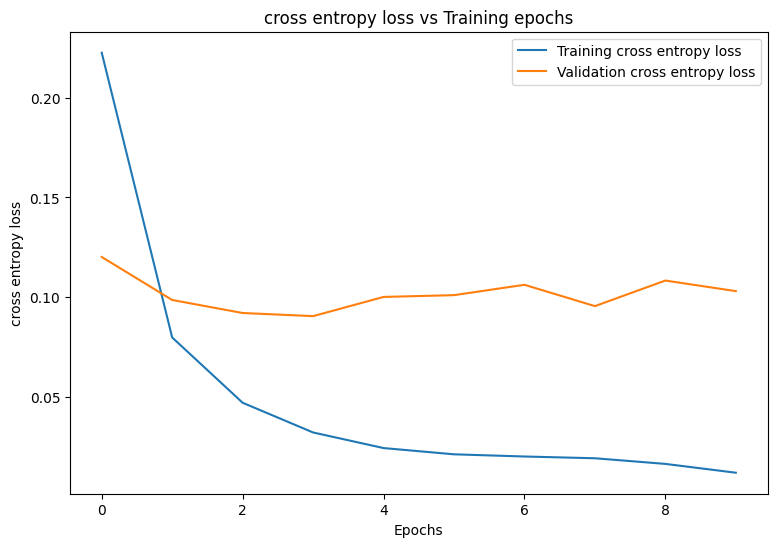

In [22]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

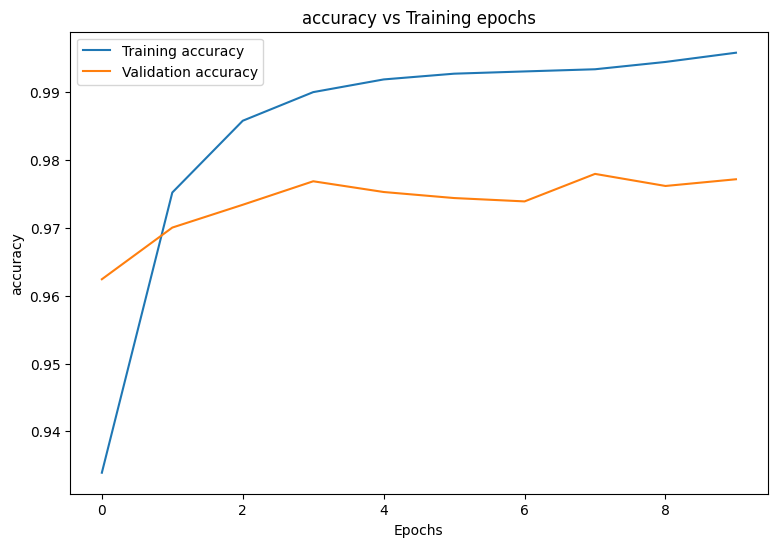

In [23]:
plot_metrics(train_accs, val_accs, "accuracy")

## Save and load the model

Start by making an export module that takes in raw data and performs the following operations:
- Data preprocessing 
- Probability prediction
- Class prediction

In [24]:
class ExportModule(tf.Module):
  def __init__(self, model, preprocess, class_pred):
    # Initialize pre and postprocessing functions
    self.model = model
    self.preprocess = preprocess
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, None, None], dtype=tf.uint8)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.preprocess(x)
    y = self.model(x)
    y = self.class_pred(y)
    return y 

In [25]:
def preprocess_test(x):
  # The export module takes in unprocessed and unlabeled data
  x = tf.reshape(x, shape=[-1, 784])
  x = x/255
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return tf.argmax(tf.nn.softmax(y), axis=1)

This export module can now be saved with the `tf.saved_model.save` function. 

In [26]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

In [27]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmphtbcg1os/mlp_model_export/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmphtbcg1os/mlp_model_export/assets


Load the saved model with `tf.saved_model.load` and examine its performance on the unseen test data.

In [28]:
mlp_loaded = tf.saved_model.load(save_path)

In [29]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.979


The model does a great job of classifying handwritten digits in the training dataset and also generalizes well to unseen data. Now, examine the model's class-wise accuracy to ensure good performance for each digit. 

In [30]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 4: 0.960
Digit 7: 0.967
Digit 3: 0.969
Digit 6: 0.973
Digit 8: 0.977
Digit 9: 0.984
Digit 0: 0.989
Digit 2: 0.990
Digit 5: 0.991
Digit 1: 0.993


It looks like the model struggles with some digits a little more than others which is quite common in many multiclass classification problems. As a final exercise, plot a confusion matrix of the model's predictions and its corresponding true labels to gather more class-level insights. Sklearn and seaborn have functions for generating and visualizing confusion matrices. 

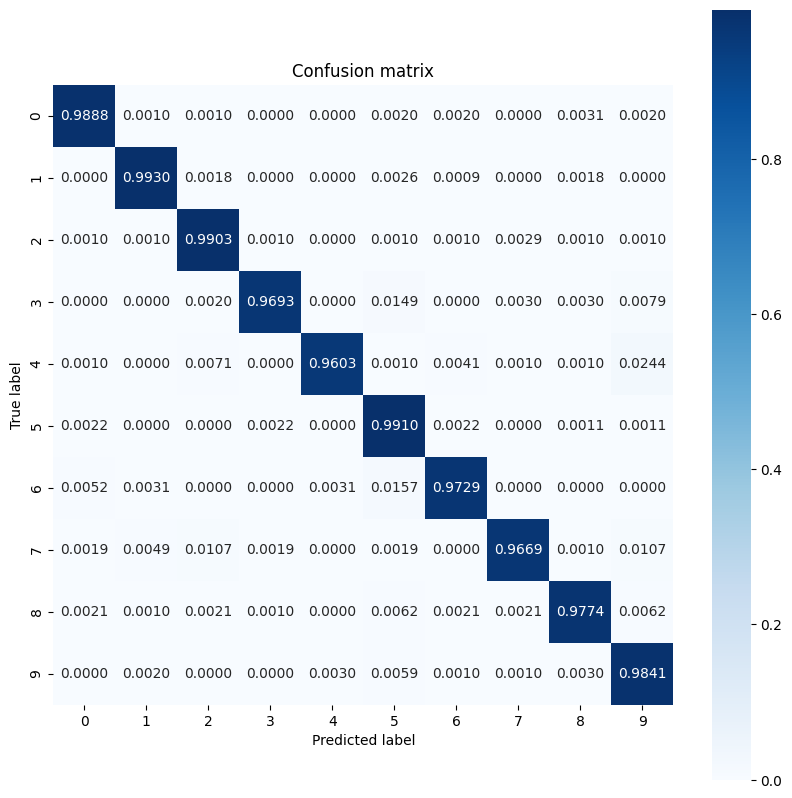

In [31]:
import sklearn.metrics as sk_metrics

def show_confusion_matrix(test_labels, test_classes):
  # Compute confusion matrix and normalize
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(test_labels.numpy(), 
                                          test_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(10)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(y_test, test_classes)

Class-level insights can help identify reasons for misclassifications and improve model performance in future training cycles.

## Conclusion

This notebook introduced a few techniques to handle a multiclass classification problem with an [MLP](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax). Here are a few more tips that may help:

- The [TensorFlow Core APIs](https://www.tensorflow.org/guide/core) can be used to build machine learning workflows with high levels of configurability
- Initialization schemes can help prevent model parameters from vanishing or exploding during training.
- Overfitting is another common problem for neural networks, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.

For more examples of using the TensorFlow Core APIs, check out the [guide](https://www.tensorflow.org/guide/core). If you want to learn more about loading and preparing data, see the tutorials on [image data loading](https://www.tensorflow.org/tutorials/load_data/images) or [CSV data loading](https://www.tensorflow.org/tutorials/load_data/csv).